# Model ResNet

https://www.pluralsight.com/guides/introduction-to-resnet

#### TODOS
1. DONE Debugging, does output make sense?
    1. Resize images
    2. preprocessing fixes
    5. replace scaling by proper function
2. try on leaderboard
3. Include Odometry and fuse into heads
    - Speed
    - Location
4. navigation
5. controller
6. Evaluation on Test set, Modularization



## Dependencies

In [1]:
# MODEL STUFF
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# GENERAL STUFF
import time
import copy
import os
import sys
from tqdm import tqdm

import pandas as pd

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append("../../data_pipeline")
# import data_sampler, dataset
from data_sampler import WeightedSampler
from dataset import CARLADataset #, CARLADatasetMultiProcessing
from utils import train_test_split, create_metadata_df

## Model

In [3]:
class MyResnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        
        # ResNet Architecture with pretrained weights, also bigger resnets available
        self.net = torchvision.models.resnet18(pretrained=True) # weights=True
        num_ftrs = self.net.fc.in_features

        # Top layer of ResNet which you can modify. We choose Identity to use it as Input for all the heads
        self.net.fc = nn.Identity()
        
        # Input Layer fuer cmd, spd
        self.cmd_input = nn.Sequential(
            nn.Linear(7, 7),
            nn.LeakyReLU() # TODO
        )
        
        self.spd_input = nn.Sequential(
            nn.Linear(1, 1),
            nn.LeakyReLU() # TODO
        )
        
        # Regression Heads for Throttle, Brake and Steering
        self.thr_head = nn.Sequential(
            nn.Linear(num_ftrs+8, 1),
            nn.Sigmoid() # [0,1] Range Output
        )
        
        self.brk_head = nn.Sequential(
            nn.Linear(num_ftrs+8, 1),
            nn.Sigmoid() # [0,1] Range Output
        )
        
        self.str_head = nn.Sequential(
            nn.Linear(num_ftrs+8, 1),
            nn.Tanh() # [-1,1] Range Output
        )

    # Forward Pass of the Model
    def forward(self, rgb, cmd, spd):
        rgb = self.net(rgb) # BRG
        cmd = self.cmd_input(cmd)
        spd = self.spd_input(spd)
        
        x = torch.cat((rgb, cmd, spd),1)
        
        #x = self.net.fc(x)
        return self.thr_head(x), self.str_head(x), self.brk_head(x) # 3 Outputs since we have 3 Heads

## Data Loaders, Data Sets

In [4]:
# path_data = "../../data/Dataset Ege/Dataset Ege 1"
path_data = os.path.join("..", "..", "data", "data")

# train_path = "../input" #data must be shared publically, doing local for now
# test_path = "../input"

config = {"used_inputs": ["rgb","measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "seq_len": 1
        }

df_meta_data = create_metadata_df(path_data, config["used_inputs"])
df_meta_data_train, df_meta_data_test = train_test_split(df_meta_data, towns={"train": ["Town04"], "test": ["Town05"]}) # "Town06"
# Make test set the 15% of the size of the train set
df_meta_data_train = df_meta_data_train.head(5*64)
df_meta_data_test = df_meta_data_test.sample(n=int(df_meta_data_train.shape[0] * 0.15), random_state=3)
# df_meta_data_train, df_meta_data_test = df_meta_data.head(int(258866/120)), df_meta_data.head(int(258866/120))

train_dataset = CARLADataset(root_dir=path_data, df_meta_data=df_meta_data_train, config=config)
test_dataset = CARLADataset(root_dir=path_data, df_meta_data=df_meta_data_test, config=config)

# weighted_sampler = WeightedSampler(dataset=train_dataset)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



train_dataloader_mp = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader_mp = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [5]:
len(train_dataloader)

5

In [6]:
train_dataset.get_statistics()

,rgb_in_GB,measurements_in_GB,time_hours
0,0.074017,0.001402,0.044444


In [7]:
len(test_dataloader)

1

In [8]:
test_dataset.get_statistics()

,rgb_in_GB,measurements_in_GB,time_hours
0,0.010514,0.000211,0.006667


In [9]:
mean = torch.tensor([79.6657, 81.5673, 105.6161])
std = torch.tensor([66.8309, 60.1001, 66.2220])


transform_norm = transforms.Compose([
    transforms.Normalize(mean, std)
])


## Training

In [10]:
# Initialise Model (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
print(device)
net = MyResnet()
net.to(device)

mps


/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyResnet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [11]:
def to_cuda_if_possible(data):
    return data.to(device) if device else data

In [12]:
def forward_pass(data):
    # further preprocessing
    start_prep = time.time()
    X_rgb = torch.squeeze(transform_norm(data["rgb"])).float()
    labels = data["command"]
    # labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0
    labels = torch.where(labels == -1, torch.tensor(0, dtype=labels.dtype), labels).to(torch.int64) # Replace by -1 by 0
    # Convert the labels to a one hot encoded tensor
    one_hot = torch.nn.functional.one_hot(labels, num_classes=7)
    X_cmd = torch.squeeze(one_hot).float()
    X_spd = ((data["speed"]-speed_mean)/speed_std).float()
    
    Y_throttle = data["throttle"].float()
    Y_steer = data["steer"].float()
    Y_brake = data["brake"].float()
    end_prep = time.time()
    time_prep = end_prep - start_prep
    # move to GPU
    start_trans_cuda = time.time()
    X_rgb = to_cuda_if_possible(X_rgb)
    X_cmd = to_cuda_if_possible(X_cmd)
    X_spd = to_cuda_if_possible(X_spd)
    
    Y_throttle = to_cuda_if_possible(Y_throttle)
    Y_steer = to_cuda_if_possible(Y_steer)
    Y_brake = to_cuda_if_possible(Y_brake)
    end_trans_cuda = time.time()
    time_trans_cuda = end_trans_cuda - start_trans_cuda
    # compute outputs
    start_forward = time.time()
    optimizer.zero_grad()
    Y_hat = net(X_rgb, X_cmd, X_spd)
    end_forward = time.time()
    time_forward = end_forward - start_forward
    start_trans_cuda_2 = time.time()
    Y_hat_throttle = to_cuda_if_possible(Y_hat[0])
    Y_hat_steer = to_cuda_if_possible(Y_hat[1])
    Y_hat_brake = to_cuda_if_possible(Y_hat[2])

    # get labels from data
    Y_throttle = to_cuda_if_possible(data["throttle"].float())
    Y_steer = to_cuda_if_possible(data["steer"].float())
    Y_brake = to_cuda_if_possible(data["brake"].float())
    end_trans_cuda_2 = time.time()
    time_trans_cuda_2 = end_trans_cuda_2 - start_trans_cuda_2

    # Calculate Loss
    start_loss = time.time()
    loss_throttle = 0.7*criterion(Y_hat_throttle, Y_throttle)
    loss_steer = 0.2*criterion(Y_hat_steer, Y_steer)
    loss_brake = 0.1*criterion(Y_hat_brake, Y_brake)
    loss = sum([loss_throttle, loss_steer, loss_brake])
    end_loss = time.time()
    time_loss = end_loss - start_loss
    return loss, time_prep, time_trans_cuda, time_forward, time_trans_cuda_2, time_loss

In [13]:
# Loss and Optimizer
criterion = nn.L1Loss() # Easy to interpret #nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) #optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Model Trainer Prototype

In [14]:
"""
Checking time consumption in training pipeline:
- Data Loading: cannot directly measure it because done in for loop itself and other stuff in for loop
- Data Preprocessing
- Training step
- Validation step

"""

'\nChecking time consumption in training pipeline:\n- Data Loading: cannot directly measure it because done in for loop itself and other stuff in for loop\n- Data Preprocessing\n- Training step\n- Validation step\n\n'

In [15]:
speed_mean = 2.250456762830466
speed_std = 0.30215840254891313

In [16]:
times_prep, times_trans_cuda, times_forward, times_trans_cuda_2, times_loss, times_backprop, times_val, times_epoch, times_monitoring = [], [], [], [], [], [], [], [], []

In [17]:
%%time

n_epochs = 10
print_every = 200
valid_loss_min = np.Inf
val_loss = []
train_loss = []
total_step = len(train_dataloader)

validate = True

for epoch in range(1, n_epochs+1):
    start_epoch = time.time()
    
    running_loss = 0.0
    print(f'Epoch {epoch}\n')
    
    # Work through batches
    for batch_idx, data in enumerate(train_dataloader):
        
        loss, time_prep, time_trans_cuda, time_forward, time_trans_cuda_2, time_loss = forward_pass(data)
        times_prep.append(time_prep)
        times_trans_cuda.append(time_trans_cuda)
        times_forward.append(time_forward)
        times_trans_cuda_2.append(time_trans_cuda_2)
        times_loss.append(time_loss)

        start_backprop = time.time()
        # Backprop
        loss.backward()
        optimizer.step()
        end_backprop = time.time()
        time_backprop = end_backprop - start_backprop
        times_backprop.append(time_backprop)
        
        start_monitoring = time.time()
        running_loss += loss.item()
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        end_monitoring = time.time()
        time_monitoring = end_monitoring - start_monitoring
        times_monitoring.append(time_monitoring)
        
    # Epoch finished, evaluate network and save if network_learned
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f},') # TODO SOLVE NAN ISSUES
    batch_loss = 0

    
    # Evaluation on Test set, skipped for now
    
    start_val = time.time()
    if validate:
        with torch.no_grad():
            net.eval()
            
            for batch_idx, data in enumerate(test_dataloader):
                
                loss, time_prep, time_trans_cuda, time_forward, time_trans_cuda_2, time_loss = forward_pass(data)
                
                batch_loss += loss.item()
            val_loss.append(batch_loss/len(test_dataloader))
            #network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, \n') # TODO SOLVE NAN ISSUES

            
            if False:#network_learned:
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), 'resnet.pt')
                print('Improvement-Detected, save-model')
    end_val = time.time()
    time_val = end_val - start_val
    times_val.append(time_val)

    # Back to training
    net.train()
    end_epoch = time.time()
    time_epoch = end_epoch - start_epoch
    times_epoch.append(time_epoch)
    

Epoch 1



/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/10], Step [0/5], Loss: 0.3451

train-loss: 0.3160,
validation loss: 0.3766, 

Epoch 2

Epoch [2/10], Step [0/5], Loss: 0.2370

train-loss: 0.2759,
validation loss: 0.3695, 

Epoch 3

Epoch [3/10], Step [0/5], Loss: 0.1797

train-loss: 0.2438,
validation loss: 0.3624, 

Epoch 4

Epoch [4/10], Step [0/5], Loss: 0.1168

train-loss: 0.2165,
validation loss: 0.3530, 

Epoch 5

Epoch [5/10], Step [0/5], Loss: 0.1257

train-loss: 0.1959,
validation loss: 0.3393, 

Epoch 6

Epoch [6/10], Step [0/5], Loss: 0.0966

train-loss: 0.1778,
validation loss: 0.3340, 

Epoch 7

Epoch [7/10], Step [0/5], Loss: 0.0830

train-loss: 0.1647,
validation loss: 0.3341, 

Epoch 8

Epoch [8/10], Step [0/5], Loss: 0.0709

train-loss: 0.1531,
validation loss: 0.3313, 

Epoch 9

Epoch [9/10], Step [0/5], Loss: 0.0576

train-loss: 0.1429,
validation loss: 0.3283, 

Epoch 10

Epoch [10/10], Step [0/5], Loss: 0.0561

train-loss: 0.1343,
validation loss: 0.3238, 

CPU times: user 19.7 s, sys: 27.5 s, total: 47.

In [18]:
torch.save(net, f"rgb_resnet_num_epochs_{n_epochs}.pth")

In [19]:
import pandas as pd

In [20]:
def get_speed_stats():
    df_speed_stats = pd.DataFrame({
    "times_prep" : times_prep, 
    "times_trans_cuda" : times_trans_cuda, 
    "times_forward": times_forward, 
    "times_trans_cuda_2" : times_trans_cuda_2, 
    "times_loss" : times_loss, 
    "times_backprop" : times_backprop, 
    "times_monitoring" : times_monitoring, 
    })
    df_speed_stats = df_speed_stats.sum().to_frame().T
    df_speed_stats["time_val"] = times_val[0]
    df_speed_stats["time_untracked"] = times_epoch[0] - df_speed_stats.sum().sum()
    df_speed_stats = df_speed_stats.T
    df_speed_stats.columns = ["time_sec"]
    df_speed_stats["time_%"] = (df_speed_stats["time_sec"] / df_speed_stats["time_sec"].sum() * 100).round(2)
    df_speed_stats = df_speed_stats.sort_values(by="time_%", ascending=False)
    return df_speed_stats

In [21]:
df_speed_stats = get_speed_stats()
df_speed_stats

,time_sec,time_%
times_monitoring,42.607438,320.64
times_trans_cuda_2,17.093697,128.64
times_backprop,13.543936,101.93
times_prep,2.659955,20.02
times_forward,0.912748,6.87
times_trans_cuda,0.608273,4.58
time_val,0.574949,4.33
times_loss,0.492535,3.71
time_untracked,-65.205406,-490.70


In [22]:
def get_performance_stats():
    df_performance_stats = pd.DataFrame({
    "train_loss" : train_loss, 
    "train_loss_throttle" : train_loss_throttle, 
    "train_loss_brake": train_loss_brake, 
    "train_loss_steer" : train_loss_steer,
    "val_loss" : val_loss, 
    "val_loss_throttle" : val_loss_throttle, 
    "val_loss_brake" : val_loss_brake,
    "val_loss_steer" : val_loss_steer 
    })
    return df_performance_stats

In [23]:
df_performance_stats = get_performance_stats()
df_performance_stats.to_pickle(f"df_perf_rgb_resnet_num_epochs_{n_epochs}.pkl")

NameError: name 'train_loss_throttle' is not defined

In [ ]:
df_performance_stats = pd.read_pickle("df_perf_rgb_resnet_num_epochs_10.pkl")

<AxesSubplot: xlabel='Epoch', ylabel='Mean L1 Loss'>

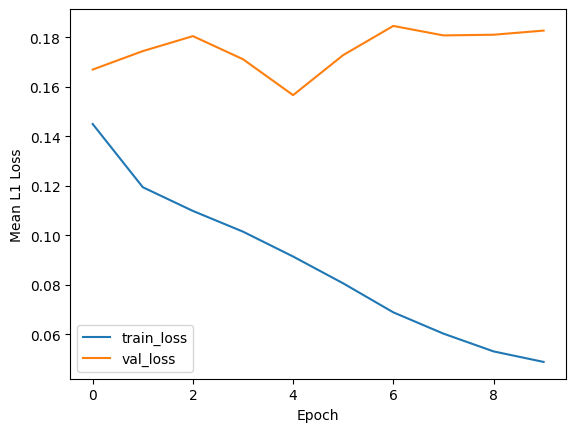

In [ ]:
df_performance_stats[["train_loss", "val_loss"]].plot(xlabel="Epoch", ylabel="Mean L1 Loss",)

<AxesSubplot: >

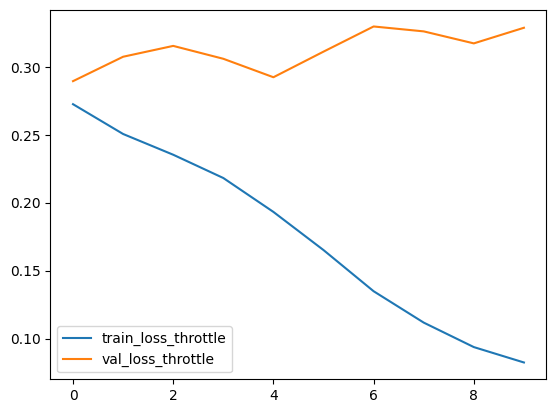

In [ ]:
df_performance_stats[["train_loss_throttle", "val_loss_throttle"]].plot()

<AxesSubplot: >

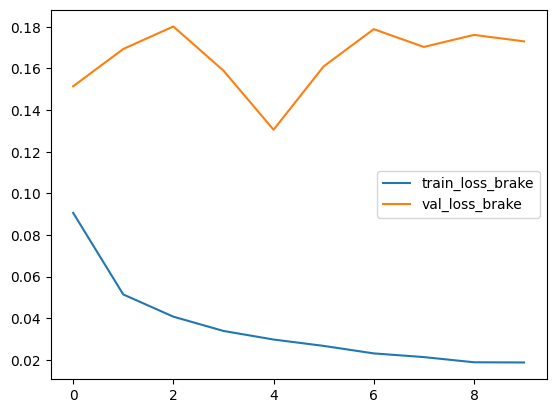

In [ ]:
df_performance_stats[["train_loss_brake", "val_loss_brake"]].plot()

<AxesSubplot: >

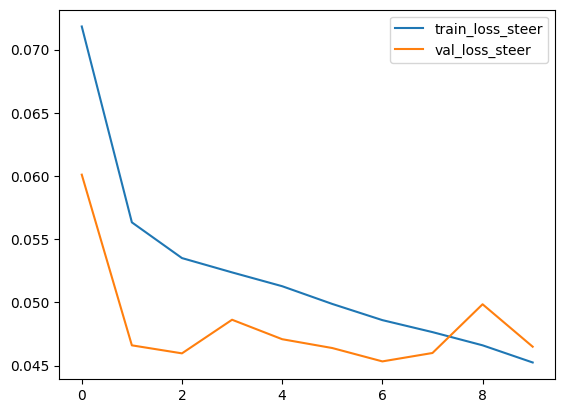

In [ ]:
df_performance_stats[["train_loss_steer", "val_loss_steer"]].plot()

In [ ]:
# df_speed_stats.to_pickle("df_speed_stats_benchmark.pkl")